# Two Outliers (Section 4.4)

In [1228]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from linear_regression import LinearRegression

In [ ]:
# set random seed for reproducibility.
np.random.seed(6)

### Data Generation.

In [1308]:
np.random.seed(6)

In [1309]:
# number of red crosses.
num_red_crosses = 1000

# set variance of the red crosses.
var2 = 1

# generate the design matrix.
# generate 2 black dots.
x1 = np.expand_dims([-50,50], axis=0) # - (shift both points right by 10)
# 1000 red crosses.
x2 = np.random.randn(1, num_red_crosses) * np.sqrt(var2)
# concatenate x.
x = np.concatenate([x1, x2], axis=-1).T
# add in the all-1s column for the intercept term.
df = pd.DataFrame(x)
df.insert(0, 'Ones', 1)
x = df.values
x1 = x[:2]
x2 = x[2:]

# generate y.
# customize the placement of y for the 2 black dots. 
y1 = np.expand_dims([-50, 50], axis=1)
# generate y according to y_n = beta2 * x2_n + epsilon2 for the 1000 red crosses.
beta2 = -1
noise_stdev = 1
epsilon2 = noise_stdev * np.random.randn(num_red_crosses, 1)
y2 = np.expand_dims(x2[:,1].T * beta2, axis=1) + epsilon2
y = np.concatenate([y1, y2], axis=0)
y = y.flatten()
y2 = y2.flatten()

### Cross Leverage Computations.

In [1232]:
# Compute the inverse Covariance Matrix.
A = np.linalg.inv(x.T @ x)
# Compute the Hat Matrix.
H = x @ A @ x.T
# Compute the Least-Squares Estimator.
Betahat = np.linalg.inv(x.T @ x) @ x.T @ y

In [1233]:
# compute DFBETAs for the black dots.
dfbeta0 = 1/ (1 - H[0, 0]) * A @ x[0] * (y[0] - x[0].T @ Betahat)
dfbeta1 = 1/ (1 - H[1, 1]) * A @ x[1] * (y[1] - x[1].T @ Betahat)
print(f"DFBETA for the 1st black dot: {dfbeta0[1]}")
print(f"DFBETA for the 2nd black dot: {dfbeta1[1]}")
# compute residuals for the black dots.
residual0 = y[0] - x[0].T @ Betahat
residual1 = y[1] - x[1].T @ Betahat


DFBETA for the 1st black dot: 0.22983654726481254
DFBETA for the 2nd black dot: 0.22847334352590756


In [1235]:
black_dots_cross_leverage = x[0].T @ np.linalg.inv(x.T @ x) @ x[1]
print(f"Cross leverage score for the 2 black dots: {round(black_dots_cross_leverage, 4)}")
mean_cross_leverage = np.mean([x[i-1].T @ np.linalg.inv(x.T @ x) @ x[i] for i in range(3, len(x))])
print(f"Mean cross leverage score for the 1000 red crosses: {round(mean_cross_leverage, 4)}")

Cross leverage score for the 2 black dots: -0.4205
Mean cross leverage score for the 1000 red crosses: 0.001


In [1242]:
# compute the fit of the first black dot.
y1_pred_full = x1[0].T @ lr.beta
print(f'The fit of the bottom left black dot is {y1_pred_full}.')
# compute the fit of the first black dot with the second black dot removed.
y1_pred_noTR = x1[0].T @ lr_noTR.beta
print(f'The fit of the bottom left black dot with the top right black dot removed is {y1_pred_noTR}.')
# compute the difference in the fits.
y1_pred_diff = y1_pred_noTR - y1_pred_full
print(f'The impact of dropping the top right black dot on the fit of the bottom left black dot is {y1_pred_diff}.')

# compute the fit of the second black dot.
y2_pred_full = x1[1].T @ lr.beta
print(f'The fit of the top right black dot is {y2_pred_full}.')
# compute the fit of the second black dot with the first black dot removed.
y2_pred_noBL = x1[1].T @ lr_noBL.beta
print(f'The fit of the top right black dot with the bottom left black dot removed is {y2_pred_noBL}.')
# compute the difference in the fits.
y2_pred_diff = y2_pred_noBL - y2_pred_full
print(f'The impact of dropping the bottom left black dot on the fit of the top right black dot is {y2_pred_diff}.')

The fit of the bottom left black dot is -34.251043722504335.
The fit of the bottom left black dot with the top right black dot removed is -22.856436597273458.
The impact of dropping the top right black dot on the fit of the bottom left black dot is 11.394607125230877.
The fit of the top right black dot is 34.3580643692659.
The fit of the top right black dot with the bottom left black dot removed is 22.891417027918013.
The impact of dropping the bottom left black dot on the fit of the top right black dot is -11.466647341347883.


In [1243]:
min_distance = np.inf
for i in range(len(x2)):
    distance = np.sqrt((x1[0][1] - x2[i][1])**2 + (y1[0] - y2[i])**2)
    if distance < min_distance:
        min_distance = distance
print(f'The minimum distance between the lower left black dot and the closest red cross is {min_distance}.')

min_distance = np.inf
for i in range(len(x2)):
    distance = np.sqrt((x1[1][1] - x2[i][1])**2 + (y1[1] - y2[i])**2)
    if distance < min_distance:
        min_distance = distance
print(f'The minimum distance between the upper right black dot and the closest red cross is {min_distance}.')

print(f'The two black dots are around equidistant from the red crosses.')

The minimum distance between the lower left black dot and the closest red cross is [68.23850034].
The minimum distance between the upper right black dot and the closest red cross is [68.55925797].
The two black dots are around equidistant from the red crosses.


In [1247]:
print(f'The ratio of residuals is {residual0 / residual1} while the cross-leverage is {H[0,1]}.')

The ratio of residuals is -1.0068419055856026 while the cross-leverage is -0.42054803135618374.


### Model Fitting.

Fit the data using OLS regression.

In [1310]:
# dataset after dropping the black dot in the bottom left.
x_noBL = x[1:]
y_noBL = y[1:]

# dataset after dropping the black dot in the top right.
x_noTR = np.concatenate([x[:1], x[2:]], axis=0)
y_noTR = np.concatenate([y[:1], y[2:]], axis=0)

In [1311]:
lr = LinearRegression(x=x.T, y=y)
lr.fit()
lr_inliers = LinearRegression(x=x2.T, y=y2)
lr_inliers.fit()
lr_noBL = LinearRegression(x=x_noBL.T, y=y_noBL)
lr_noBL.fit()
lr_noTR = LinearRegression(x=x_noTR.T, y=y_noTR)
lr_noTR.fit()
print(
    f"Estimated beta for full data: {round(lr.beta[1], 4)} \n"
    f"Estimated beta for red crosses: {round(lr_inliers.beta[1], 4)} \n"
    f"Estimated beta for red crosses and black dot 1: {round(lr_noBL.beta[1], 4)} \n"
    f"Estimated beta for red crosses and black dot 2: {round(lr_noTR.beta[1], 4)}"
)

Estimated beta for full data: 0.6861 
Estimated beta for red crosses: -1.0006 
Estimated beta for red crosses and black dot 1: 0.4563 
Estimated beta for red crosses and black dot 2: 0.4576


In [1312]:
print(f'the impact of dropping both black dots together, {lr_inliers.beta[1] - lr.beta[1]},\nis greater than the sum of the impacts of dropping each black dot individually,\n {lr_noBL.beta[1] - lr.beta[1]} + {lr_noTR.beta[1] - lr.beta[1]} = {lr_noBL.beta[1] - lr.beta[1] + lr_noTR.beta[1] - lr.beta[1]}.')

the impact of dropping both black dots together, -1.686683771743974,
is greater than the sum of the impacts of dropping each black dot individually,
 -0.22983654726481234 + -0.2284733435259066 = -0.45830989079071893.


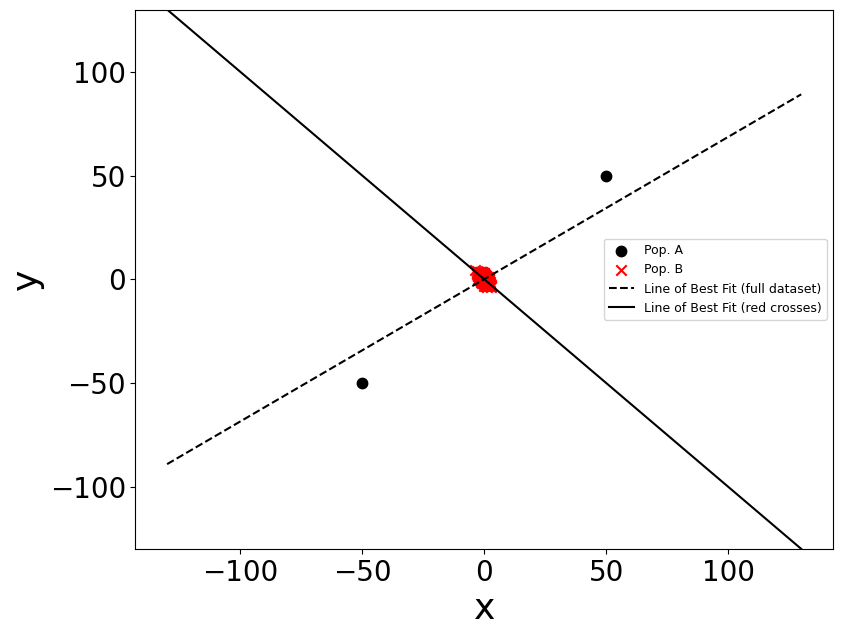

In [1313]:
plt.figure(figsize=(9, 7))

plt.scatter(x1[:, 1], y1, marker='o', color='black', label='Pop. A', s=56)
plt.scatter(x2[:, 1], y2, marker='x', color='r', label='Pop. B', s=56)

x_values = np.linspace(-130, 130, 100)
y_values_full = lr.beta[1] * x_values
y_values_noBL = lr_noBL.beta[1] * x_values
y_values_noTR = lr_noTR.beta[1] * x_values
y_value_red_crosses = lr_inliers.beta[1] * x_values
plt.plot(x_values, y_values_full, color='black', linestyle='--', label='Line of Best Fit (full dataset)') 
plt.plot(x_values, y_value_red_crosses, color='black', label='Line of Best Fit (red crosses)')
# plt.plot(x_values, y_values_noBL, color='green', label='Line of Best Fit (red crosses + top right black dot)')
# plt.plot(x_values, y_values_noTR, color='blue', label='Line of Best Fit (red crosses + bottom left black dot)')

plt.xlabel('x', fontsize=26) 
plt.ylabel('y', fontsize=26)

# set range of y-axis
plt.ylim(-130, 130)

# Set the size of tick marks
plt.xticks(fontsize=20) 
plt.yticks(fontsize=20)

plt.legend(fontsize=9)
# plt.savefig('two_outlier_example.pdf')
plt.show()

### Running Additive and Greedy algorithms.

In [1314]:
def compute_scores(x, y, lr):
    '''
    x: design matrix.
    y: response vector.
    lr: linear regression model.
    '''
    if_scores = -lr.influence_scores()[1]
    newton_scores = -lr.one_step_newton()[1]

    # sort indices in ascending order.
    if_inds = np.argsort(if_scores)
    newton_inds = np.argsort(newton_scores)

    # sort scores according to indices.
    sorted_scores = if_scores[if_inds]
    sorted_newton_scores = newton_scores[newton_inds]

    # compute residuals and leverages.
    residuals = lr.residual()
    leverages = lr.leverage_scores()

    x1 = [pt[1] for pt in x]

    # create a df with residuals, leverages, and coordinates.
    orig_df = pd.DataFrame({'x': x1, 'y': y, 
                            'residual': residuals, 'leverage': leverages, 
                            'IF': if_scores, '1Exact': newton_scores,
                            'sorted_IF_indices': if_inds, 'sorted_1Exact_indices': newton_inds,
                            'sorted_IF_scores': sorted_scores, 'sorted_1Exact_scores': sorted_newton_scores})
    return orig_df

#### Additive Algorithms.

In [1315]:
two_outliers_df = compute_scores(x, y, lr)
two_outliers_df

,x,y,residual,leverage,IF,1Exact,sorted_IF_indices,sorted_1Exact_indices,sorted_IF_scores,sorted_1Exact_scores
0,-50.000000,-50.000000,-15.748956,0.422395,-0.132755,-0.229837,0,0,-0.132755,-0.229837
1,50.000000,50.000000,15.641936,0.422693,-0.131899,-0.228473,1,1,-0.131899,-0.228473
2,-0.311784,-1.106915,-0.946513,0.001013,-0.000048,-0.000048,737,737,-0.000206,-0.000206
3,0.729004,-0.889946,-1.443619,0.001090,0.000180,0.000180,776,776,-0.000139,-0.000139
4,0.217821,-0.003890,-0.206845,0.001007,0.000008,0.000008,569,569,-0.000122,-0.000122
...,...,...,...,...,...,...,...,...,...,...
997,0.085324,-0.351170,-0.463220,0.000999,0.000007,0.000007,199,199,0.002493,0.002498
998,1.891149,-1.626598,-2.977609,0.001607,0.000954,0.000955,254,254,0.002629,0.002635
999,-1.276885,1.716378,2.538927,0.001269,0.000543,0.000544,974,974,0.002740,0.002748
1000,-1.072279,0.356986,1.039156,0.001189,0.000186,0.000187,355,355,0.002901,0.002908


In [1316]:
print(f'The AMIP approximation for the change induced by dropping the worst-case subset of size at most two is {round(sum(two_outliers_df["sorted_IF_scores"][:2]), 4)}.')
print(f'The Add-1Exact for the change induced by dropping the worst-case subset of size at most two is {round(sum(two_outliers_df["sorted_1Exact_scores"][:2]), 4)}.')
print(f'The true change induced by dropping the worst-case subset of size at most two is {round((lr_inliers.beta[1] - lr.beta[1]), 4)}.')

print(f'The AMIP approximation of the refit is {round(lr.beta[1] + sum(two_outliers_df["sorted_IF_scores"][:2]), 4)}.')
print(f'The Add-1Exact for the change induced by dropping the worst-case subset of size at most two is {round(lr.beta[1] + sum(two_outliers_df["sorted_1Exact_scores"][:2]), 4)}.')
print(f'The true change induced by dropping the worst-case subset of size at most two is {round((lr_inliers.beta[1]), 4)}.')

The AMIP approximation for the change induced by dropping the worst-case subset of size at most two is -0.2647.
The Add-1Exact for the change induced by dropping the worst-case subset of size at most two is -0.4583.
The true change induced by dropping the worst-case subset of size at most two is -1.6867.
The AMIP approximation of the refit is 0.4214.
The Add-1Exact for the change induced by dropping the worst-case subset of size at most two is 0.2278.
The true change induced by dropping the worst-case subset of size at most two is -1.0006.


#### Greedy Algorithms.

In [1299]:
def create_orig_df(x, y, lr):
    '''
    x: design matrix.
    y: response vector.
    lr: linear regression object.
    '''
    # compute IF/1Exact scores.
    if_scores = -lr.influence_scores()[1]
    newton_scores = -lr.one_step_newton()[1]

    # sort indices in ascending order.
    if_inds = np.argsort(if_scores)
    newton_inds = np.argsort(newton_scores)

    # residuals
    residuals = lr.residual()
    # leverages
    leverages = lr.leverage_scores()
    # x's
    x1 = [pt[1] for pt in x]

    # create a df with residuals, leverages, and coordinates.
    orig_df = pd.DataFrame({'x1': x1, 'y': y, 
                                      'residual': residuals, 'leverage': leverages, 
                            'influence': if_scores, 'newton': newton_scores})
    
    print(orig_df[:5])
    return orig_df, if_inds, if_scores, newton_inds, newton_scores

def create_plot(orig_df):
    '''
    orig_df: output from the helper function above.
    '''

    # Sort DF by influence score
    sorted_if_df = orig_df.sort_values(by='influence', ascending=True)
    print("Point to Drop: ", sorted_if_df.index[0])
    
    # sorted_if_df: the indices here are the order which amip drops points.
    index = range(0, len(sorted_if_df))
    sorted_if_df['sorted_idx'] = index
    
    # Plot points dropped
    plt.figure(figsize=(9, 7))
    plt.scatter(orig_df[:2]['x1'], orig_df[:2]['y'], marker='x', color='black', label='Pop. A') # pop A
    plt.scatter(orig_df[2:]['x1'], orig_df[2:]['y'], marker='x', color='r', label='Pop. B') # pop B

    # Add dropped order positioned by each point
    for index, row in sorted_if_df.iterrows():
        if row['sorted_idx'] <= 9: # indices 2,3,4 are right on top of one another.
            plt.text(row['x1'], row['y'], int(row['sorted_idx']), ha='left', va='top', fontsize=20)


    plt.xlabel('x1')
    plt.ylabel('y')
    plt.title('Scores Ordered')
    plt.legend()
    plt.show()
    
    return

def Run_Greedy(x, y, orig_if_inds, orig_newton_inds, lr, method='IF'):
    '''
    x: design matrix.
    y: response vector.
    orig_inds: indices sorted by the first round.
    lr: linear regression object.
    method: 'IF' or '1Exact'.
    '''
    ctr = 0
    prev_beta = lr.beta[1] # initialize to the original beta estimate.
    dropped_order = []
    exact_changes_beta = []
    beta_estimates_greedy = []
    if_inds = orig_if_inds
    newton_inds = orig_newton_inds

    for _ in range(3):
        print(f'interation {ctr}')

        if method == 'IF':
            inds = if_inds
        else:
            inds = newton_inds
        
        # 1. drop the datapoint with the most negative influence:
        index_to_remove = inds[0]
        print("index to remove", index_to_remove)

        dropped_order.append(index_to_remove)

        new_x = np.concatenate((x[:index_to_remove], x[index_to_remove + 1:]))
        new_y = np.concatenate((y[:index_to_remove], y[index_to_remove + 1:]))

        x = new_x
        y = new_y

        # 2. calculate the exact perturbation (ie. refit the lr to get the change in the coefficient.)
        lr = LinearRegression(x=x.T, y=y)
        lr.fit()
        print(f'fitted beta1: {lr.beta[1]}')

        # 3. compute scores and create plot.
        orig_df, if_inds, if_scores, newton_inds, newton_scores = create_orig_df(x, y, lr)
        create_plot(orig_df)

        # 4. record: the exact change in beta.
        beta_change = lr.beta[1] - prev_beta
        exact_changes_beta.append(beta_change)
        prev_beta = lr.beta[1]
        beta_estimates_greedy.append(lr.beta[1])

        # counter
        ctr += 1

    return dropped_order, exact_changes_beta, beta_estimates_greedy

In [1305]:
# store the original x and y.
orig_x = x
orig_y = y

# compute scores for initial round of the greedy algorithm.
orig_df, if_inds, if_scores, newton_inds, newton_scores = create_orig_df(orig_x, orig_y, lr)

orig_inds_if = if_inds
orig_inds_newton = newton_inds
# compute influence scores.
if_scores = -lr.influence_scores()[1]
# sort indices in ascending order.
if_inds = np.argsort(if_scores)
print("inds", if_inds[:10])
newton_inds = np.argsort(newton_scores)
print("newton_inds", newton_inds[:10])

# reset greedy loop.
x = orig_x
y = orig_y

len(residuals) 1002
len(x1) 1002
len(y) 1002
          x1          y   residual  leverage  influence    newton
0 -50.000000 -50.000000 -15.571209  0.423716  -0.131492 -0.228173
1  50.000000  50.000000  15.757514  0.421761  -0.132757 -0.229589
2  -1.260993   1.393402   2.352495  0.001291   0.000523  0.000524
3  -1.024372  -0.626880   0.169722  0.001196   0.000031  0.000031
4  -0.182401  -1.316678  -1.098269  0.001008  -0.000045 -0.000045
inds [  1   0  74 541 777 938 275 114 476 211]
newton_inds [  1   0  74 541 777 938 275 114 476 211]


interation 0
index to remove 1
fitted beta1: 0.4571238581196852
len(residuals) 1001
len(x1) 1001
len(y) 1001
          x1          y   residual  leverage  influence    newton
0 -50.000000 -50.000000 -27.036764  0.729858  -0.394056 -1.458698
1  -1.260993   1.393402   2.076875  0.001468   0.000768  0.000769
2  -1.024372  -0.626880  -0.051572  0.001310  -0.000016 -0.000016
3  -0.182401  -1.316678  -1.126256  0.001010  -0.000063 -0.000063
4  -1.209049   1.336816   1.996544  0.001431   0.000708  0.000709
Point to Drop:  0


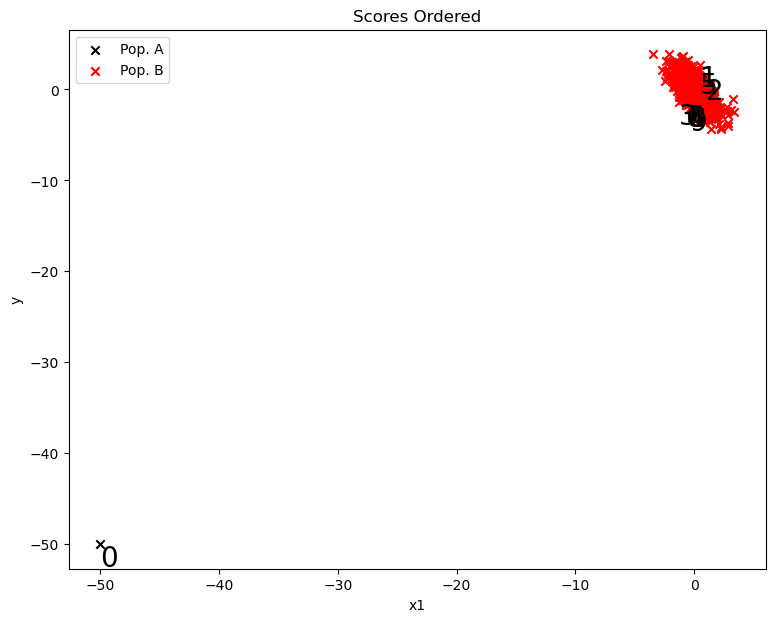

interation 1
index to remove 0
fitted beta1: -1.0015745903177349
len(residuals) 1000
len(x1) 1000
len(y) 1000
         x1         y  residual  leverage  influence    newton
0 -1.260993  1.393402  0.125718  0.002875   0.000179  0.000179
1 -1.024372 -0.626880 -1.657570  0.002263  -0.001934 -0.001938
2 -0.182401 -1.316678 -1.504071  0.001062  -0.000390 -0.000390
3 -1.209049  1.336816  0.121157  0.002731   0.000165  0.000166
4 -1.086511  1.335836  0.242909  0.002412   0.000300  0.000300
Point to Drop:  958


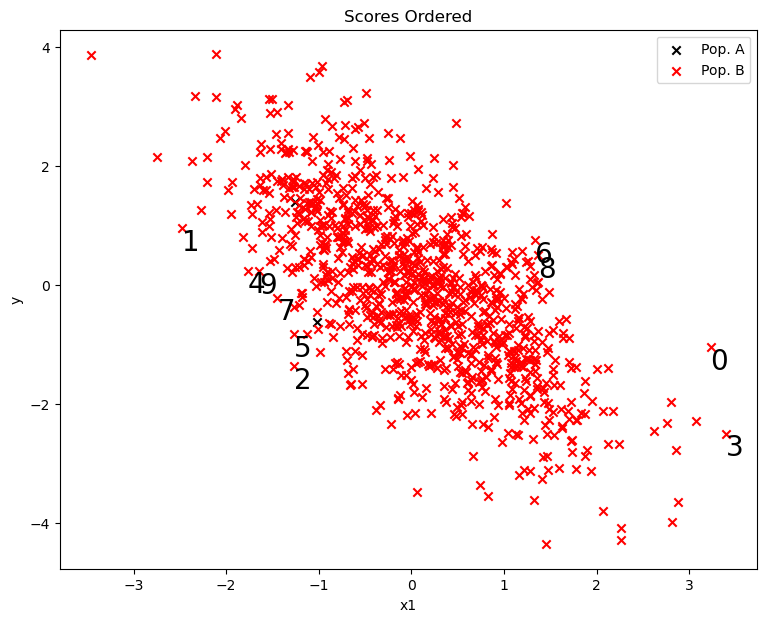

interation 2
index to remove 958
fitted beta1: -1.0091329010554475
len(residuals) 999
len(x1) 999
len(y) 999
         x1         y  residual  leverage  influence    newton
0 -1.260993  1.393402  0.117960  0.002888   0.000169  0.000170
1 -1.024372 -0.626880 -1.663539  0.002270  -0.001956 -0.001961
2 -0.182401 -1.316678 -1.503677  0.001062  -0.000389 -0.000389
3 -1.209049  1.336816  0.113792  0.002742   0.000157  0.000157
4 -1.086511  1.335836  0.236470  0.002421   0.000294  0.000295
Point to Drop:  992


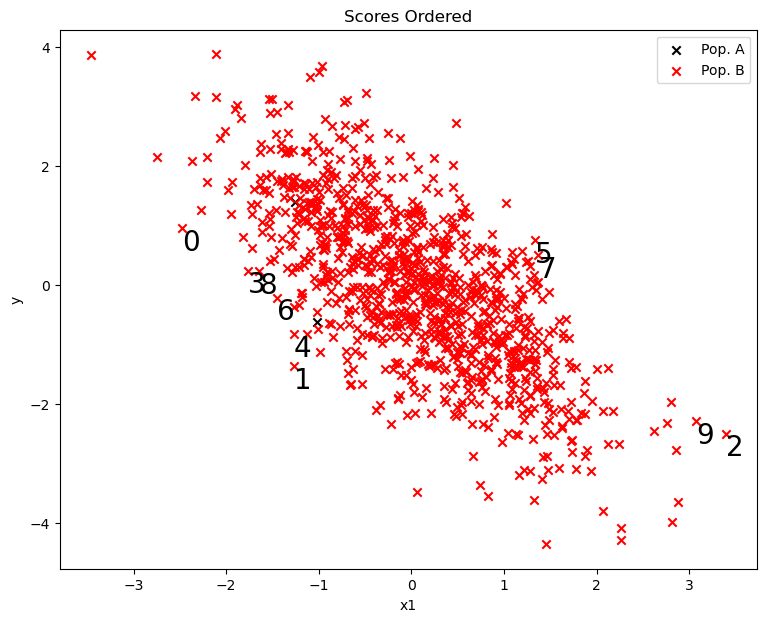

dropped order: 
 [1, 0, 958]
exact (greedy) beta estimates: 
 [0.4571238581196852, -1.0015745903177349, -1.0091329010554475]


In [1303]:
# run greedy
dropped_order, exact_changes_beta, beta_estimates_greedy = Run_Greedy(orig_x, orig_y, orig_inds_if, orig_inds_newton, lr, method='1Exact')

print("dropped order: \n", dropped_order[:5])
print("exact (greedy) beta estimates: \n", beta_estimates_greedy[:5])